# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [2]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

# Your work here.

## Load Libraries

In [219]:
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set()

from statsmodels.graphics.gofplots import qqplot  # for Q-Q Plot 

from scipy.stats import shapiro  # for normality test: Shapiro-Wilk test 
from scipy.stats import normaltest  # for normality test: D’Agostino’s K^2 Test
from scipy.stats import anderson  # for normality test: Anderson-Darling Test
from scipy.stats import ttest_ind, ttest_1samp  # two-sample, one-sample t-test
from statsmodels.stats.weightstats import ztest  # z-test

import numpy as np 
np.random.seed(42)

## User Define Functions

In [83]:
def _normality_test_shapiro(data, alpha=0.05): 
    ### normality test: Shapiro-Wilk Test ###
    stat, p = shapiro(data)
    print('Shapiro-Wilk Test: Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    if p > alpha:
        print('- Gaussian (fail to reject H0)')
    else:
        print('- Non-Gaussian (reject H0)')

In [84]:
def _normality_test_normaltest(data, alpha=0.05): 
    ### normality test: D’Agostino’s K^2 Test ###
    stat, p = normaltest(data)
    print('D\'Agostino\'s K^2\' Test: Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    if p > alpha:
        print('- Gaussian (fail to reject H0)')
    else:
        print('- Non-Gaussian (reject H0)')

In [85]:
def _normality_test_anderson(data): 
    ### normality test: Shapiro-Wilk Test ###
    result = anderson(data)
    print('Anderson Statistic: %.3f' % result.statistic)
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('- %.3f: %.3f, Guassian (fail to reject H0)' % (sl, cv))
        else:
            print('- %.3f: %.3f, Non-Gaussian (reject H0)' % (sl, cv))

In [188]:
def _boostrap_replicate_1d(data, func, size):
    ### generate bootstrap replicate on 1d array ###
    bs_sample = np.random.choice(data, size=size)
    return func(bs_sample)

In [128]:
def _ecdf(data):
    ### Compute Empirical Cumulative Distribution Function (ECDF) for a one-dimensional array of measurements. ###
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n
    return x, y

## Understand the data

The dataset contains 130 instances, recording the body temperature ($^{\circ}$F) of 65 male and 65 female samples. The data range appears to be normal with lowest temperature at 96.3$^{\circ}$F or 35.7$^{\circ}$C and highest temperature at 100.8$^{\circ}$F or 38.2$^{\circ}$C. 

From the histogram/KDE (Kernal Density Estimate) plots, 
* The mean temperature of female samples (98.4$^{\circ}$F) is higher than that of male samples (98.1$^{\circ}$F). 
* Compare to the distribution of body temperature of male samples, the distribution of female samples cover a larger temperature range, but with majority of the samples concentrated in a narrower band. 

In [3]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [4]:
df.describe()

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


In [30]:
# Count the number of samples for each gender
df[['temperature','gender']].groupby('gender').agg(['count','mean','std'])

temperature                     
             count       mean       std
gender                                 
F               65  98.393846  0.743488
M               65  98.104615  0.698756

<IPython.core.display.Javascript object>


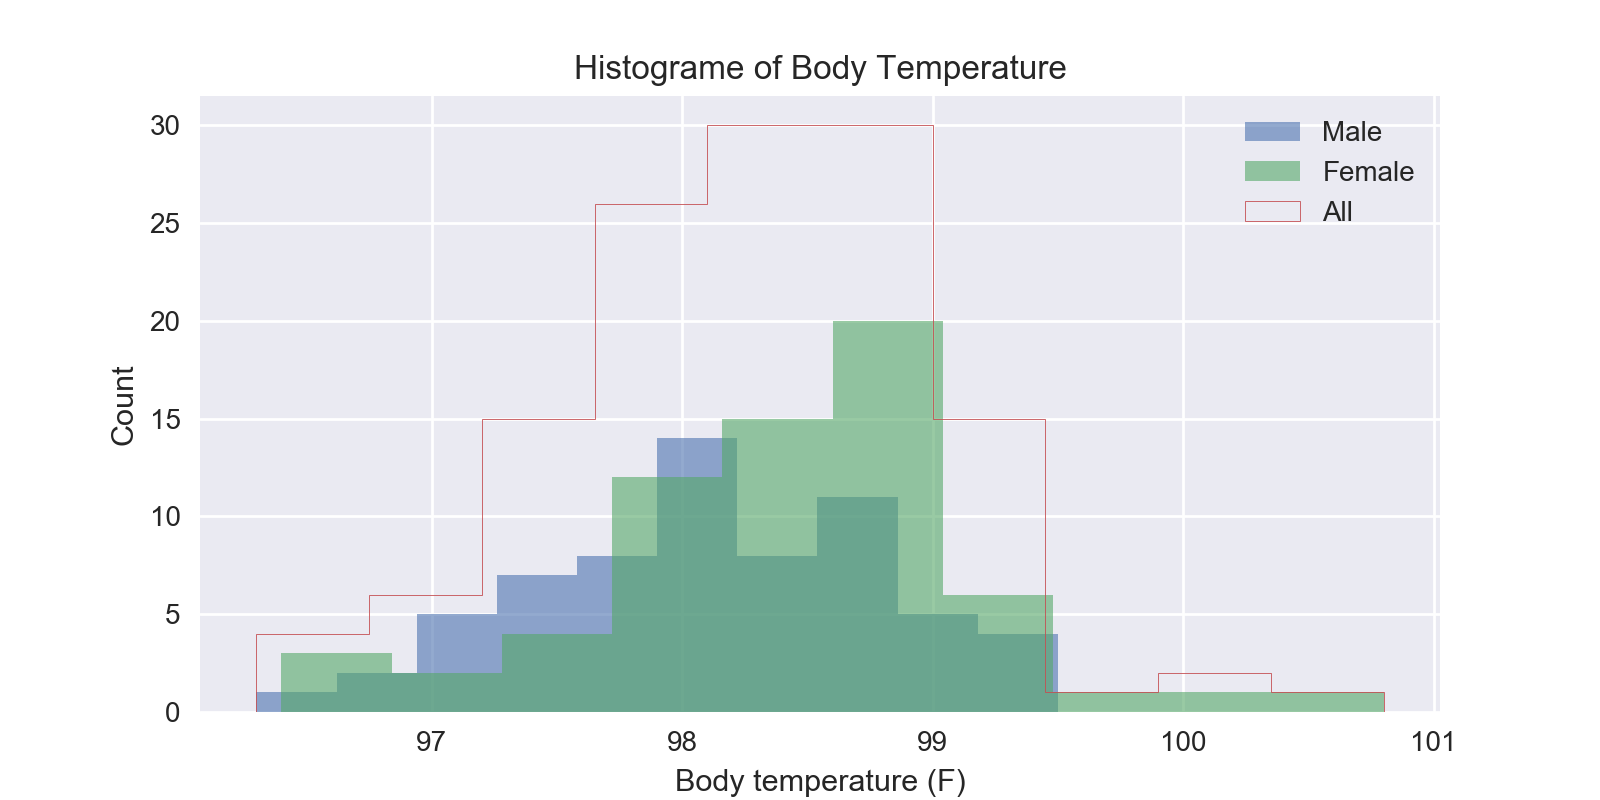

In [39]:
# Histogram of Body Temperature (be aware of binning bias!)
plt.figure(figsize = (8, 4))
plt.hist(df.loc[df['gender'] == 'M', 'temperature'].reset_index(drop=True), alpha=0.6, label="Male")
plt.hist(df.loc[df['gender'] == 'F', 'temperature'].reset_index(drop=True), alpha=0.6, label="Female")
plt.hist(df['temperature'].reset_index(drop=True), histtype='step', alpha=1, label="All")
plt.xlabel('Body temperature (F)')
plt.ylabel('Count') 
plt.legend()
plt.title('Histograme of Body Temperature')
plt.show()

## Answer to Exercises

### Is the distribution of body temperatures normal?

<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>

#### Step 1: Graphical method (Histograme/KDE + Q-Q Plot)
Other than only look at the distribution of the whole dataset, it is further split into two subgroups according to the gender. The distributions appear qualitatively to be Gaussian-like in both KDE and Q-Q plots. 

<IPython.core.display.Javascript object>


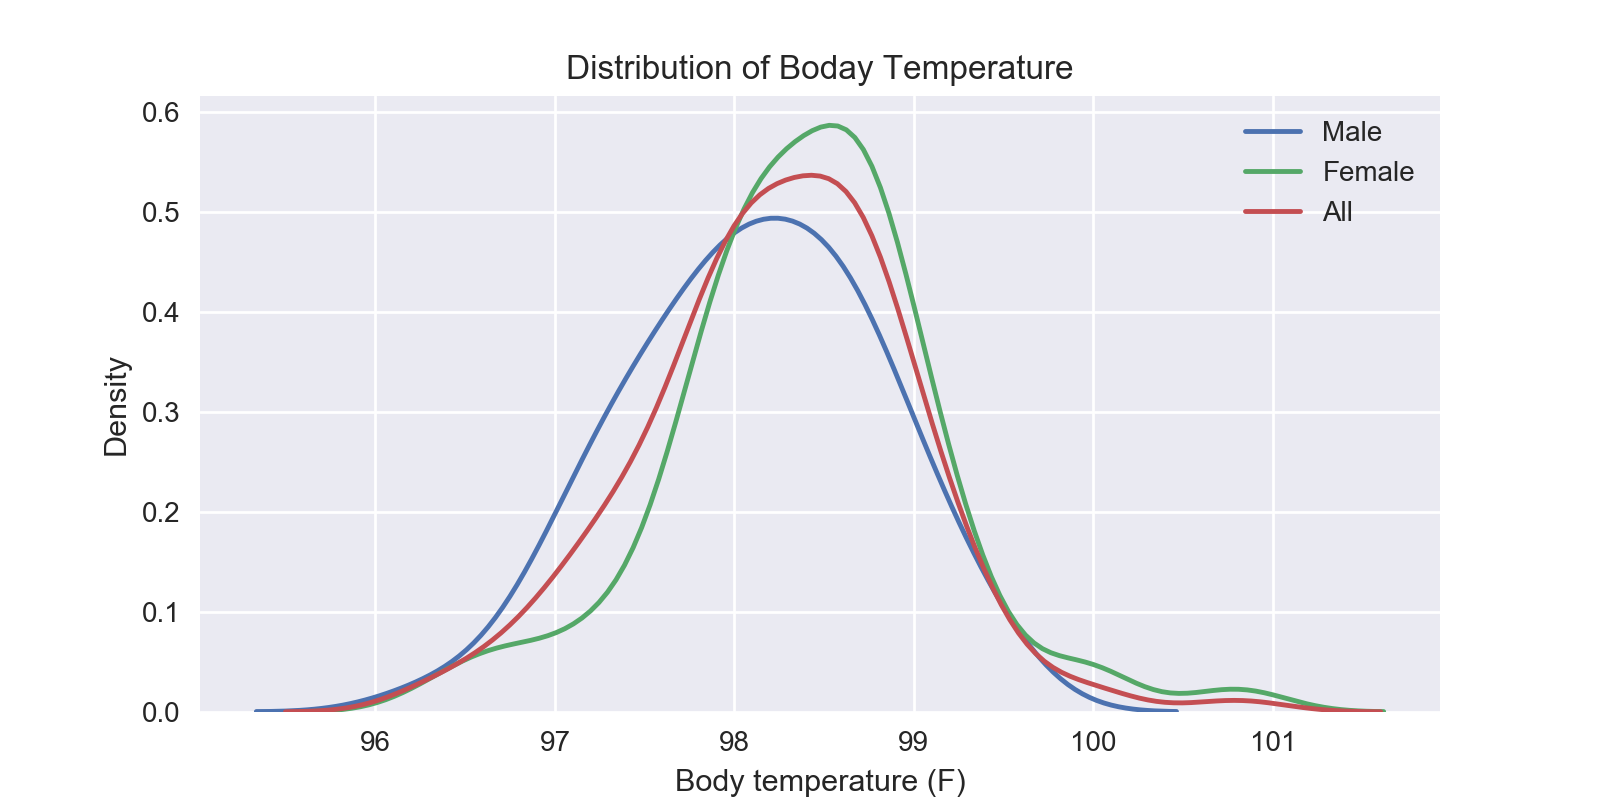

In [41]:
# KDE plot of boday temperature
plt.figure(figsize = (8, 4))
sns.kdeplot(df.loc[df['gender'] == 'M', 'temperature'], label = 'Male')
sns.kdeplot(df.loc[df['gender'] == 'F', 'temperature'], label = 'Female')
sns.kdeplot(df['temperature'], label = 'All')
plt.xlabel('Body temperature (F)'); 
plt.ylabel('Density'); 
plt.title('Distribution of Boday Temperature');
plt.show()

<IPython.core.display.Javascript object>


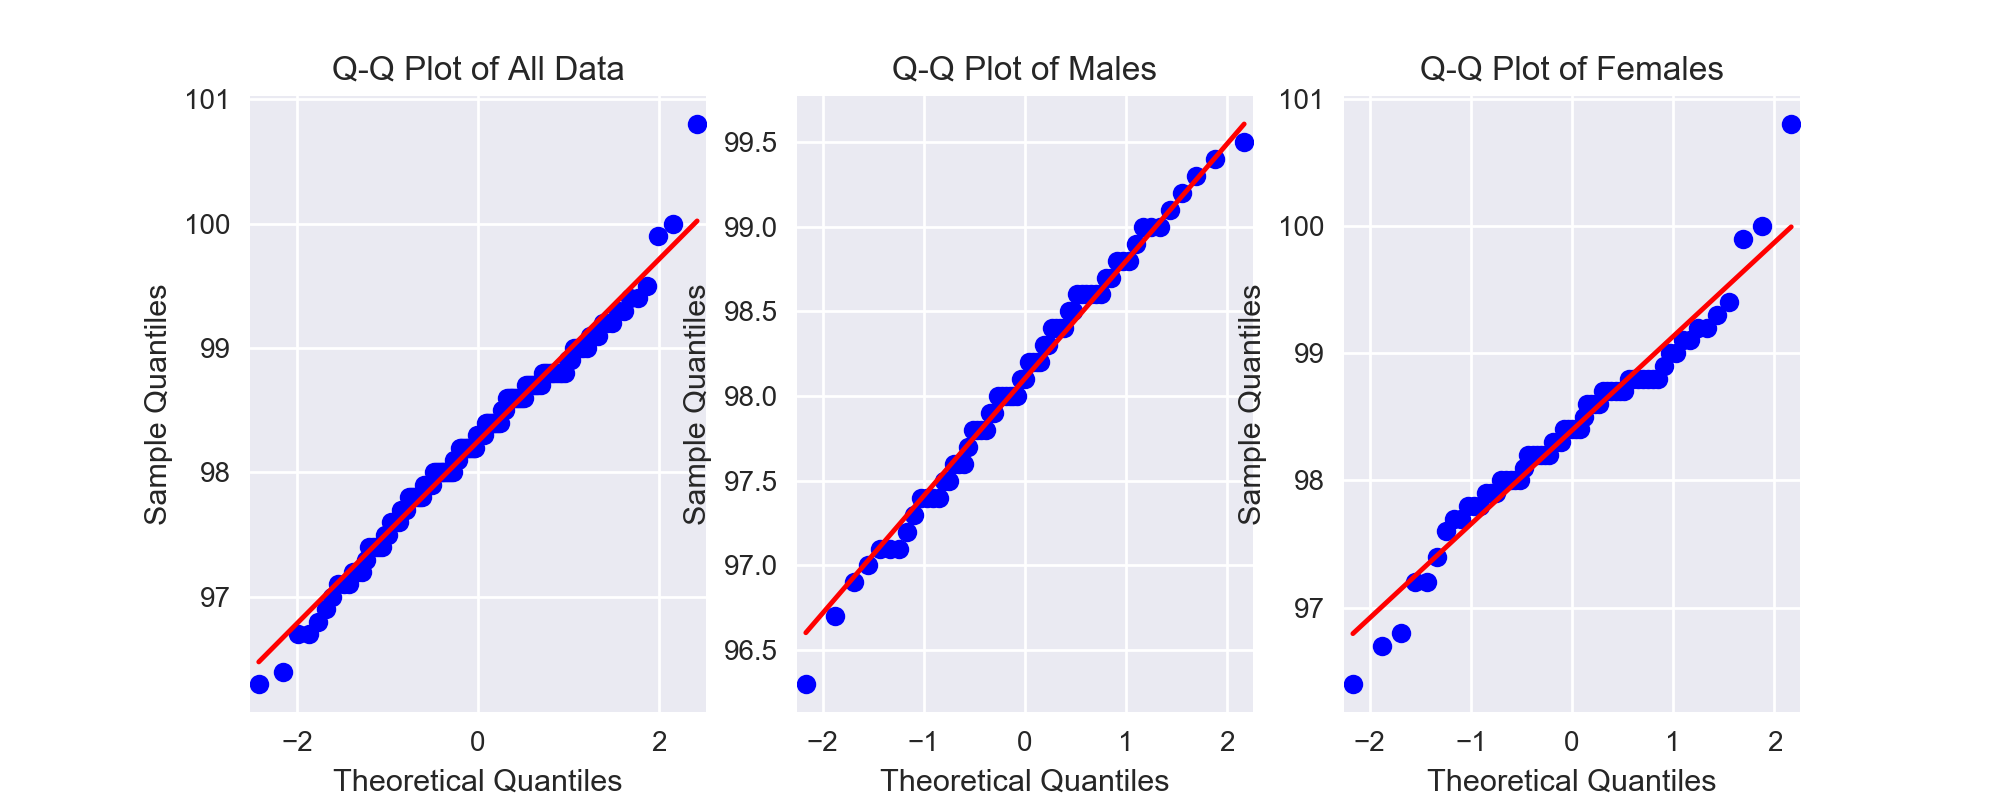

In [61]:
# Quantile-Quantile Plot
plt.figure(figsize = (10, 4))
ax = plt.subplot(1, 3, 1)
qqplot(df['temperature'], line='s', ax=ax)
plt.title('Q-Q Plot of All Data')
ax = plt.subplot(1, 3, 2)
qqplot(df.loc[df['gender'] == 'M', 'temperature'], line='s', ax=ax)
plt.title('Q-Q Plot of Males')
ax = plt.subplot(1, 3, 3)
qqplot(df.loc[df['gender'] == 'F', 'temperature'], line='s', ax=ax)
plt.title('Q-Q Plot of Females');

#### Step 2: Statistical Tests

In this section, several quantitative statistical test method will be applied to test the normality of the dataset, including: 
* Shapiro-Wilk Test
* D’Agostino’s K^2 Test
* Anderson-Darling Test


Ref: A Gentle Introduction to Normality Tests in Python - by Jason Brownlee <br>
https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

Each test will return at least two things:
* Statistic: A quantity calculated by the test that can be interpreted in the context of the test via comparing it to critical values from the distribution of the test statistic.
* p-value: Used to interpret the test, in this case whether the sample was drawn from a Gaussian distribution.

Hypothesis Test: 
* H0 (Null Hypothesis) = the distribution is Gaussian
* Threshold (alpha) = 0.05 (typical value)
* To interpret
* p <= alpha: reject H0, not normal.
* p > alpha: fail to reject H0, normal.

Which test to use? 
* Use all and check if it is hard/soft fail
* Hard fail (i.e. all fail): data is not nornal
* Soft fail (i.e. some fail): data can still be approximated as Gaussian like

**It is found that the dataset has passed all three normality tests, and the female samples are less normal-like than the male samples.**

In [147]:
print("\n$ Normality test on All Data")
_normality_test_shapiro(df['temperature'])
_normality_test_normaltest(df['temperature'])
_normality_test_anderson(df['temperature'])

print("\n$ Normality test on Male Samples")
_normality_test_shapiro(df.loc[df['gender'] == 'M', 'temperature'])
_normality_test_normaltest(df.loc[df['gender'] == 'M', 'temperature'])
_normality_test_anderson(df.loc[df['gender'] == 'M', 'temperature'])

print("\n$ Normality test on Female Samples")
_normality_test_shapiro(df.loc[df['gender'] == 'F', 'temperature'])
_normality_test_normaltest(df.loc[df['gender'] == 'F', 'temperature'])
_normality_test_anderson(df.loc[df['gender'] == 'F', 'temperature'])


$ Normality test on All Data
Shapiro-Wilk Test: Statistics=0.987, p=0.233
- Gaussian (fail to reject H0)
D'Agostino's K^2' Test: Statistics=2.704, p=0.259
- Gaussian (fail to reject H0)
Anderson Statistic: 0.520
- 15.000: 0.560, Guassian (fail to reject H0)
- 10.000: 0.637, Guassian (fail to reject H0)
- 5.000: 0.765, Guassian (fail to reject H0)
- 2.500: 0.892, Guassian (fail to reject H0)
- 1.000: 1.061, Guassian (fail to reject H0)

$ Normality test on Male Samples
Shapiro-Wilk Test: Statistics=0.989, p=0.855
- Gaussian (fail to reject H0)
D'Agostino's K^2' Test: Statistics=0.891, p=0.640
- Gaussian (fail to reject H0)
Anderson Statistic: 0.208
- 15.000: 0.546, Guassian (fail to reject H0)
- 10.000: 0.621, Guassian (fail to reject H0)
- 5.000: 0.746, Guassian (fail to reject H0)
- 2.500: 0.870, Guassian (fail to reject H0)
- 1.000: 1.034, Guassian (fail to reject H0)

$ Normality test on Female Samples
Shapiro-Wilk Test: Statistics=0.968, p=0.090
- Gaussian (fail to reject H0)
D'Ag

### Is the sample size large? Are the observations independent?

<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>

The Central Limit Theorem states that the sampling distribution of the sample means approaches a normal distribution as the sample size gets larger — no matter what the shape of the population distribution. This fact holds especially true for sample sizes over 30. <br>
Ref: http://www.statisticshowto.com/probability-and-statistics/normal-distributions/central-limit-theorem-definition-examples/

In [91]:
# Check if sample size is large, using Rule of Thumb (>30)
sample_size = df.shape[0]
large_sample_threshold = 30
if sample_size > large_sample_threshold:
    print('Sample size {} is considered large.'.format(sample_size))
else:
    print('Sample size {} is considered small.'.format(sample_size))

Sample size 130 is considered large.


**The observations are considered as independent** as the temperature was supposed to be take from different objects, and thus not correlated with each other. A detailed looked at the source of data reveals that this dataset is actual reconstructed based on certain reported distribution, but it doesn't affect the independence among observations. <br>
Ref: http://ww2.amstat.org/publications/jse/v4n2/datasets.shoemaker.html

### Is the true population mean really 98.6 degrees F?
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>

#### Bootstrap Hypothesis Test

##### Step 1: State the hypothesis and test statistics (i.e., mean)
H0: population mean = 98.6 degrees F <br>
Ha: opulation mean != 98.6 degrees F

##### Step 2: Generate many sets of simulated data assuming the null hypothesis is true.
* Compute the test statistics for each simulated dataset
* The p-value is the fraction of your simulated data set for which the test statistics is at least as extreme as real data

**Conclusion: Reject H0, population mean is different from 98.6 degrees F**

The confidence intervel with 95% CL for mean body temperature is 98.12 to 98.37 degrees F.


<IPython.core.display.Javascript object>


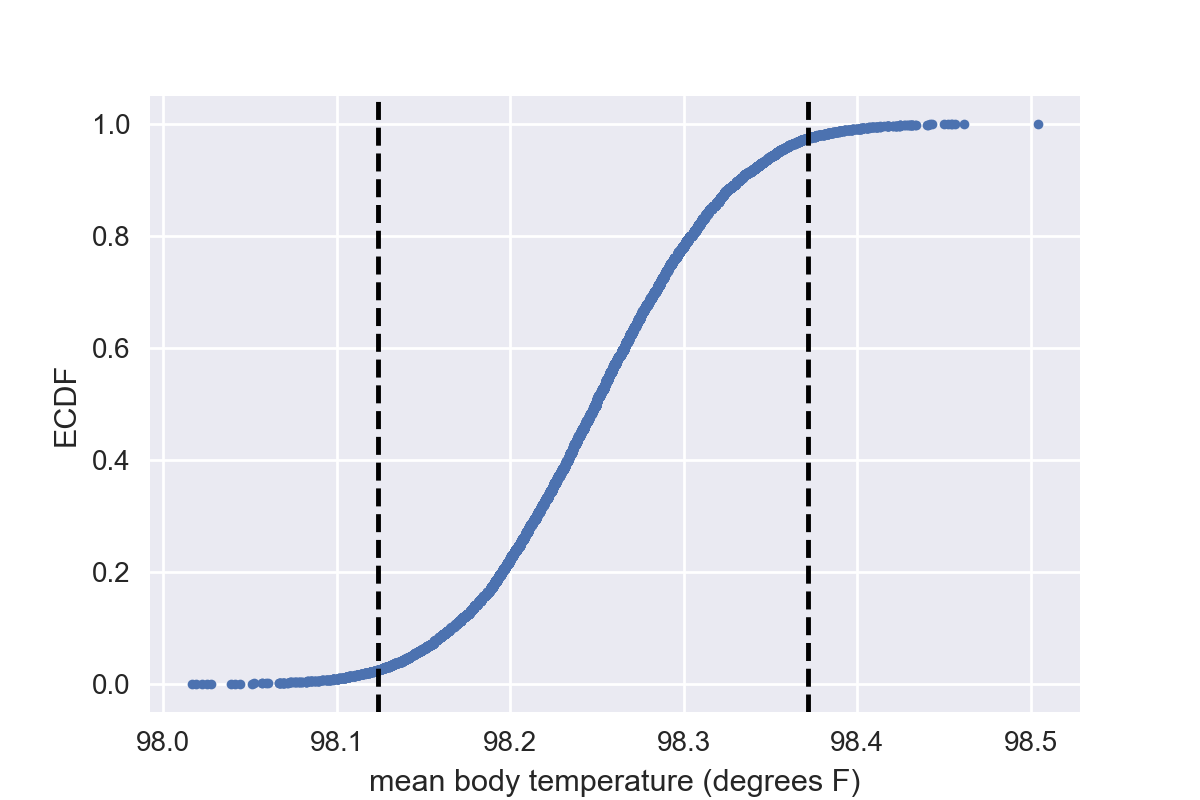

In [204]:
bs_replicates = np.empty(10000)
for i in range(10000): 
    bs_replicates[i] = _boostrap_replicate_1d(df['temperature'],np.mean,len(df))

conf_int = np.percentile(bs_replicates,[2.5, 97.5])
print('The confidence intervel with 95% CL for mean body temperature is {:.2f} to {:.2f} degrees F.'
      .format(conf_int[0],conf_int[1]))

# plot the Empirical Cumulative Distribution Function (ECDF)
plt.figure(figsize = (6, 4))
bs_x, bs_y = _ecdf(bs_replicates)
plt.plot(bs_x,bs_y,marker='.',linestyle='none')
for xc in conf_int:
    plt.axvline(x=xc, color='k', linestyle='--')
plt.xlabel('mean body temperature (degrees F)')
plt.ylabel('ECDF')
plt.show()

#### Frequentist Statistical Testing: One Sample vs. Two Sample
* A one sample test is used to compare the mean of a sample to a known value (often  0, but not always).
* A two sample test is used to compare the means of two different samples.

**To compare the mean of a sample to the population mean, one sample test is applicable.**

#### t-test vs. z-test

The general rule of thumb for when to use a t-test is when the sample:
* Has a sample size below 30,
* Has an unknown population standard deviation.

**For the current case, since the population standard deviation is unknow, t-test is more suitable. **

In [144]:
# t-test
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_1samp.html

t_stat, p_val = ttest_1samp(df['temperature'],98.6)
print('t statistics = {}, p value = {}'.format(t_stat,p_val))
if p_val < 0.05:
    print('Reject H0, polulation mean is different from 98.6 degrees F.')
else:
    print('Cannot Reject H0, polulation mean is not statistically different from 98.6 degrees F.')

t statistics = -5.4548232923645195, p value = 2.4106320415561276e-07
Reject H0, polulation mean is different from 98.6 degrees F.


In [145]:
# z-test
# http://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ztest.html#statsmodels.stats.weightstats.ztest

z_stat, p_val = ztest(df['temperature'],value=98.6)
print('z statistics = {}, p value = {}'.format(z_stat,p_val))
if p_val < 0.05:
    print('Reject H0, polulation mean is different from 98.6 degrees F.')
else:
    print('Cannot Reject H0, polulation mean is not statistically different from 98.6 degrees F.')

z statistics = -5.4548232923645195, p value = 4.9021570141012155e-08
Reject H0, polulation mean is different from 98.6 degrees F.


Comparing z-statistics and t-statistics, there is only slight difference in terms of p-value, which suggest:
* The distribution of sample data is close to normal;
* p-value of t-statistics is higher than z-statistics, meaning the area in the tail of t-statistics is relatively larger. Further increase the sample size (i.e. degree of freedom) will reduce the difference even further. 

### Small Sample of Size 10 (t-test vs. z-test again)
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>

In [185]:
np.random.seed(42)
data_sample = np.random.choice(df['temperature'], size=10)

# t-test
t_stat, p_val = ttest_1samp(data_sample,98.6)
print('t statistics = {}, p value = {}'.format(t_stat,p_val))
if p_val < 0.05:
    print('Reject H0, polulation mean is different from 98.6 degrees F.')
else:
    print('Cannot Reject H0, polulation mean is not statistically different from 98.6 degrees F.')

# z-test
z_stat, p_val = ztest(data_sample,value=98.6)
print('z statistics = {}, p value = {}'.format(z_stat,p_val))
if p_val < 0.05:
    print('Reject H0, polulation mean is different from 98.6 degrees F.')
else:
    print('Cannot Reject H0, polulation mean is not statistically different from 98.6 degrees F.')    


t statistics = -3.0934479202257976, p value = 0.012857704604809363
Reject H0, polulation mean is different from 98.6 degrees F.
z statistics = -3.0934479202257976, p value = 0.0019784527476214603
Reject H0, polulation mean is different from 98.6 degrees F.


For sample with small size (<30), t-test is the correct one to use. With smaller sample size, the difference between p-values from t-test and z-test becomes larger. This is because the distribution of smaller sample deviate more from Gaussian. 

### What temperature is "abnormal"? 
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>

In [215]:
sample_mean = np.mean(df['temperature'])
sample_std = np.std(df['temperature'])
critical_z = 3
margin_of_error = critical_z * sample_std
sample_lower_bnd = sample_mean - margin_of_error
sample_upper_bnd = sample_mean + margin_of_error
print('A body temperature out of the range {:.2f} to {:.2f} degrees F is considered abnormal.'.format(sample_lower_bnd, sample_upper_bnd))

A body temperature out of the range 96.06 to 100.44 degrees F is considered abnormal.


Question: how is this question related to bootstrap? What does it mean by one draw vs. N draw? 

### Is there a significant difference between males and females in normal temperature?
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>

In [221]:
# z-test
z_stat, p_val = ztest(df.loc[df['gender'] == 'M', 'temperature'],
                      df.loc[df['gender'] == 'F', 'temperature'],
                      value=0)
print('z statistics = {}, p value = {}'.format(z_stat,p_val))
if p_val < 0.05:
    print('Reject H0, there is a significant difference between males and females in normal temperature.')
else:
    print('Cannot Reject H0, there is no significant difference.')

z statistics = -2.2854345381656103, p value = 0.02228736076065755
Reject H0, there is a significant difference between males and females in normal temperature.


In [222]:
# two sample t-test
t_stat, p_val = ttest_ind(df.loc[df['gender'] == 'M', 'temperature'],
                          df.loc[df['gender'] == 'F', 'temperature'],
                          equal_var=False)
print('t statistics = {}, p value = {}'.format(t_stat,p_val))
if p_val < 0.05:
    print('Reject H0, there is a significant difference between males and females in normal temperature.')
else:
    print('Cannot Reject H0, there is no significant difference.')

t statistics = -2.285434538165611, p value = 0.023938264182934196
Reject H0, there is a significant difference between males and females in normal temperature.


The above statistical tests show that there is a difference between the mean temperatures of males and females in the sample. 

<IPython.core.display.Javascript object>


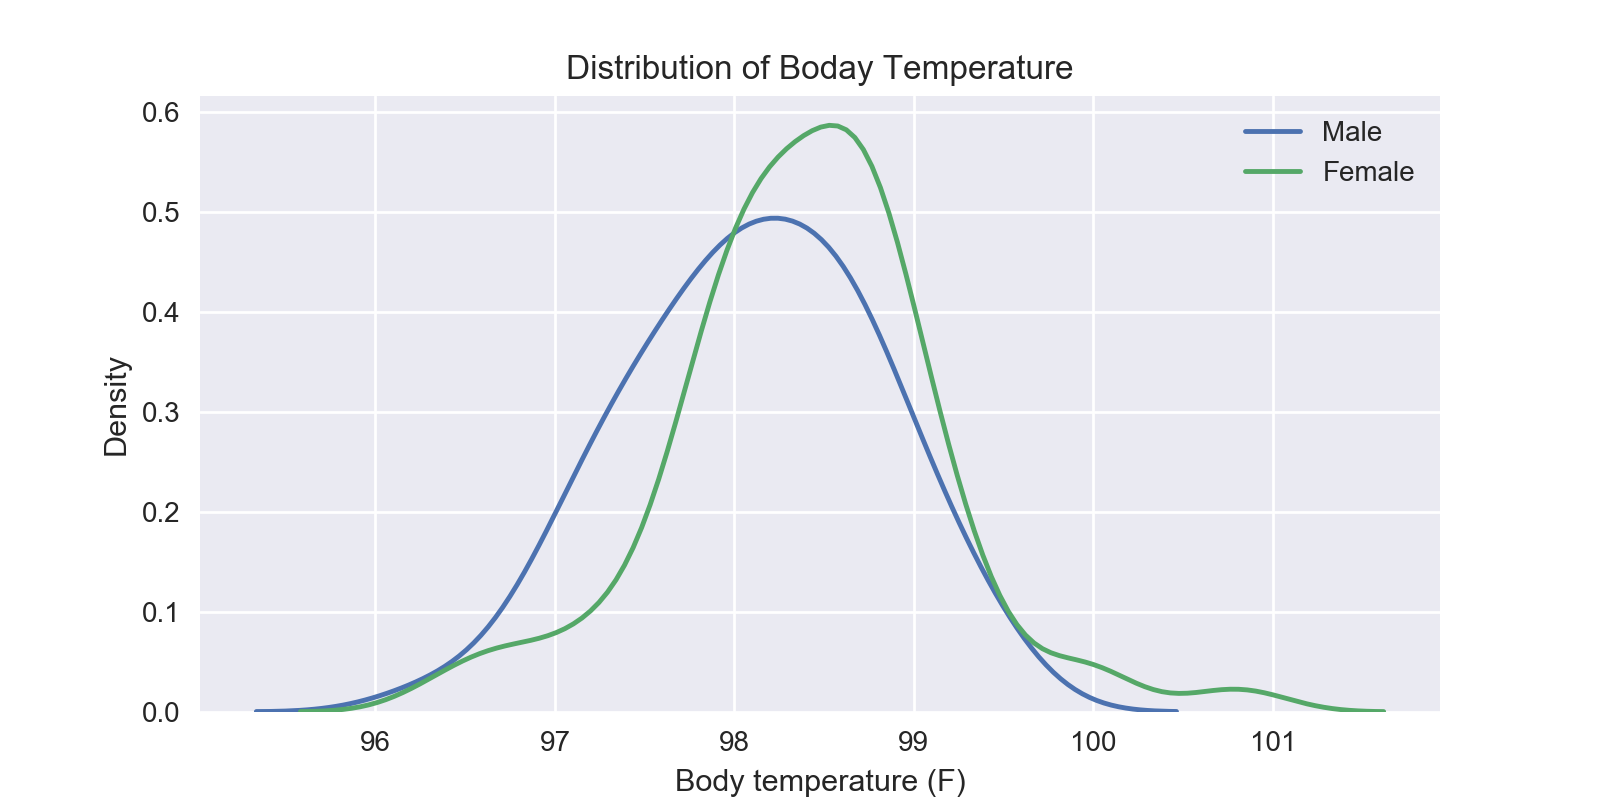

In [225]:
# KDE plot of boday temperature
plt.figure(figsize = (8, 4))
sns.kdeplot(df.loc[df['gender'] == 'M', 'temperature'], label = 'Male')
sns.kdeplot(df.loc[df['gender'] == 'F', 'temperature'], label = 'Female')
plt.xlabel('Body temperature (F)'); 
plt.ylabel('Density'); 
plt.title('Distribution of Boday Temperature');
plt.show()

============ END ============